In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline,  GenerationConfig
from accelerate import Accelerator


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-09-18 10:48:13,183] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import numpy as np
import os
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT

#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = 'dominguesm/alpaca-data-pt-br'
PATH = 'output/alpaca-data-pt-br_30000_fedavg_c60s2_i10_b16a1_l512_r8a16_20240910094609'
DEVICE = 'cuda'
NUM_CHECKPOINTS = 20
EVALSET_LEN = 50

In [12]:
# Load the data
#path = 'output/alpaca-data-pt-br_10000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240909085602/training_loss.npy'
path = 'output/aya_dataset_200000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240911152426/training_loss.npy'
#path = 'output/aya_dataset_400000_clustered_c20s2_i100_b16a1_l512_r8a16_20240913122148/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

losses

[2.141699028015137,
 2.11790246963501,
 1.9286767959594726,
 2.0705927848815917,
 2.085124683380127,
 1.9217575073242186,
 1.7471919059753418,
 2.0156527519226075,
 2.047588062286377,
 1.9321763992309569,
 1.8154597282409668,
 1.7696736335754393,
 1.8569631576538086,
 1.9623833656311036,
 1.8220419883728027,
 1.9090030670166016,
 1.9089950561523437,
 1.7163000106811523,
 1.8426593780517577,
 1.7481095314025878,
 1.954061508178711,
 1.8445809364318848,
 1.915722370147705,
 1.8607295989990233,
 1.8223953247070312,
 1.7795141220092774,
 1.8638540267944337,
 1.8543711662292481,
 1.802993392944336,
 1.7061792373657227,
 1.7689103126525878,
 1.74131441116333,
 1.8882525444030762,
 1.9013531684875489,
 1.886690616607666,
 1.8400861740112306,
 1.9172791481018066,
 1.812045955657959,
 1.723374366760254,
 1.9227869033813476,
 1.7191823959350585,
 1.9405763626098633,
 1.6877719879150392,
 1.8468783378601075,
 1.7033968925476075,
 1.7768882751464843,
 1.817511749267578,
 1.8919488906860353,
 1.833

In [13]:
path = 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240913072636/training_loss.npy'
#path = 'output/aya_dataset_400000_fedavg_c20s2_i100_b16a1_l512_r8a16_20240914133401/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

losses2

[2.142123889923096,
 2.118937683105469,
 1.928080940246582,
 2.071475696563721,
 2.0876364707946777,
 1.9240873336791993,
 1.7489052772521974,
 2.0179596900939942,
 2.049280071258545,
 1.93254976272583,
 1.8159246444702148,
 1.770007610321045,
 1.8588059425354002,
 1.9645590782165527,
 1.8233729362487794,
 1.9091639518737793,
 1.9082418441772462,
 1.7166218757629395,
 1.8446671485900878,
 1.7482483863830565,
 1.955533218383789,
 1.8448473930358886,
 1.9160567283630372,
 1.8622000694274903,
 1.8233282089233398,
 1.7799637794494627,
 1.864396858215332,
 1.855634593963623,
 1.8033231735229491,
 1.7062332153320312,
 1.7700160980224608,
 1.7412229537963868,
 1.8884472846984863,
 1.901344394683838,
 1.8864828109741212,
 1.8404247283935546,
 1.9175480842590331,
 1.8119927406311036,
 1.723681926727295,
 1.9239808082580567,
 1.719415473937988,
 1.9402151107788086,
 1.6873823165893556,
 1.8477532386779787,
 1.7029958724975587,
 1.7772493362426758,
 1.8185949325561523,
 1.891159439086914,
 1.8337

In [14]:
path = 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240917170032/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses3 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses3.append(loss)

losses3

[2.1420710563659666,
 2.1191991806030277,
 1.9286067008972168,
 2.0707054138183594,
 2.08528413772583,
 1.9228836059570313,
 1.748762321472168,
 2.0165676116943363,
 2.0487854957580565,
 1.933006191253662,
 1.815873146057129,
 1.7708498954772949,
 1.8588470458984374,
 1.9637871742248536,
 1.823218822479248,
 1.9088626861572267,
 1.908602523803711,
 1.7175443649291993,
 1.843171787261963,
 1.747867774963379,
 1.9548646926879885,
 1.8454198837280273,
 1.9164591789245606,
 1.8604652404785156,
 1.8231578826904298,
 1.7804369926452637,
 1.8648259162902834,
 1.855867290496826,
 1.802652931213379,
 1.7057412147521973,
 1.7697352409362792,
 1.7414386749267576,
 1.8885140419006348,
 1.9017367362976074,
 1.8864081382751463,
 1.83992338180542,
 1.9172147750854491,
 1.8121890068054198,
 1.7240425109863282,
 1.9238041877746581,
 1.720083999633789,
 1.9409804344177246,
 1.6867362022399903,
 1.8471354484558105,
 1.7042463302612305,
 1.7779376029968263,
 1.8159188270568847,
 1.8910337448120118,
 1.834

<Axes: ylabel='None'>

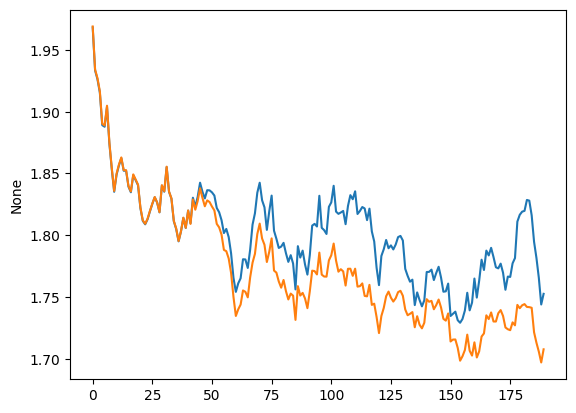

In [15]:
import seaborn as sns
import pandas as pd

#rolling mean
window = 10

losses = pd.Series(losses)
losses = losses.rolling(window).mean()
losses = losses[window:]
losses2 = pd.Series(losses2)
losses2 = losses2.rolling(window).mean()
losses2 = losses2[window:]
losses3 = pd.Series(losses3)
losses3 = losses3.rolling(window).mean()
losses3 = losses3[window:]


sns.lineplot(x=range(len(losses)), y=losses)
#sns.lineplot(x=range(len(losses2)), y=losses2)
sns.lineplot(x=range(len(losses3)), y=losses3)

In [25]:
path = 'output/aya_dataset_400000_clustered_c20s2_i100_b16a1_l512_r8a16_20240913122148/clusters_round50.npy'

clusters = np.load(path, allow_pickle=True)

In [7]:
clusters

array([1, 1, 1, 1, 4, 4, 4, 4, 5, 5, 5, 5, 2, 2, 2, 2, 3, 3, 3, 3],
      dtype=int32)

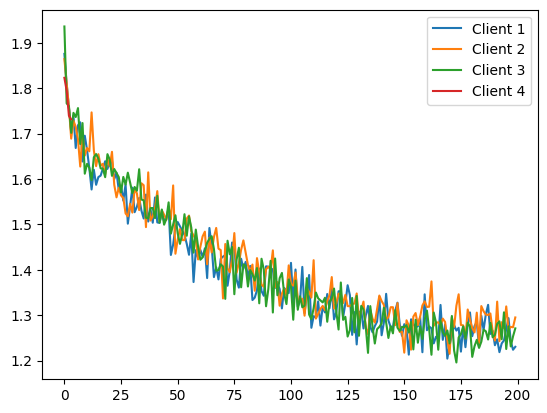

In [17]:
# Load the data
paths = ['output/alpaca-data-pt-br_10000_local1_c20s2_i10_b16a1_l512_r8a16_20240905071418',
         'output/alpaca-data-pt-br_10000_local2_c20s2_i10_b16a1_l512_r8a16_20240905071433',
         'output/alpaca-data-pt-br_10000_local3_c20s2_i10_b16a1_l512_r8a16_20240905071639',
         'output/alpaca-data-pt-br_10000_local4_c20s2_i10_b16a1_l512_r8a16_20240905071708',
         ]

for i, client in enumerate([1, 2, 3, 4]):

    path = paths[i] + '/training_loss.npy'
    data = np.load(path, allow_pickle=True)

    losses = []
    data = data.T
    for r in range(len(data)):
        loss = np.where(data[r] != -1, data[r], np.nan)
        loss = loss[~np.isnan(loss)]
        loss = loss.mean()
        losses.append(loss)

    sns.lineplot(x=range(len(losses)), y=losses, label=f'Client {client}')

In [8]:
import os

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [10]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT

#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = 'dominguesm/alpaca-data-pt-br'
PATH = 'output/alpaca-data-pt-br_30000_fedavg_c60s2_i10_b16a1_l512_r8a16_20240910094609'
DEVICE = 'cuda'
NUM_CHECKPOINTS = 20
EVALSET_LEN = 50

path = PATH + f'/checkpoint-60'
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16,
                                                quantization_config = BitsAndBytesConfig(
                                                                        load_in_4bit=True,
                                                                        bnb_4bit_use_double_quant=True,
                                                                        bnb_4bit_quant_type="nf4",
                                                                        bnb_4bit_compute_dtype=torch.bfloat16,
                                                                    ),
                                                device_map={"": Accelerator().local_process_index},)
model = PeftModel.from_pretrained(model, path).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv

In [11]:
dataset = load_dataset(DATASET_NAME, split='train').shuffle(seed=42)
dataset = dataset.select(range(500))
device = 'cuda'

Found cached dataset parquet (/home/gabriel.talasso/.cache/huggingface/datasets/dominguesm___parquet/dominguesm--alpaca-data-pt-br-5efe953862af8eb8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached shuffled indices for dataset at /home/gabriel.talasso/.cache/huggingface/datasets/dominguesm___parquet/dominguesm--alpaca-data-pt-br-5efe953862af8eb8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-b20228def560605b.arrow


In [12]:
def calculate_perplexity(instruction, output):
    # Combine instruction and output
    combined = f"{instruction} [SEP] {output}"
    
    # Tokenize
    encodings = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    
    # Calculate perplexity
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        
    return torch.exp(loss).item()

model.eval()
perplexities = []

for sample in tqdm(dataset):
    instruction = sample["instruction"] + sample["input"]

    perplexity = calculate_perplexity(instruction, sample["output"])
    perplexities.append(perplexity)

# 5. Calculate mean perplexity
mean_perplexity = np.mean(perplexities)
std_perplexity = np.std(perplexities)

print(f"Mean Perplexity: {mean_perplexity:.2f}")
print(f"Standard Deviation of Perplexity: {std_perplexity:.2f}")

# 6. (Optional) Print perplexities for each sample
#for i, (sample, perplexity) in enumerate(zip(dataset, perplexities)):
#    instruction = sample["instruction"] + sample["input"]
#    print(f"Sample {i + 1}:")
#    print(f"Instruction: {instruction}")
#    print(f"Output: {sample['output']}")
#    print(f"Perplexity: {perplexity:.2f}")
#    print("-" * 50)

100%|██████████| 500/500 [01:06<00:00,  7.48it/s]

Mean Perplexity: 60.08
Standard Deviation of Perplexity: 115.68


In [13]:
#base model
Mean Perplexity: 72.65
Standard Deviation of Perplexity: 137.91


#model with 10 rounds
Mean Perplexity: 69.00
Standard Deviation of Perplexity: 138.36


#model with 50 rounds
Mean Perplexity: 60.29
Standard Deviation of Perplexity: 115.26


#model with 100 rounds
Mean Perplexity: 60.93
Standard Deviation of Perplexity: 115.26


#model with 200 rounds
Mean Perplexity: 61.11
Standard Deviation of Perplexity: 116.74

SyntaxError: invalid syntax (2380462423.py, line 2)

In [ ]:

#model 2 with with 10 rounds
Mean Perplexity: 67.78
Standard Deviation of Perplexity: 134.27


#model 2 with with 50 rounds
Mean Perplexity: 59.74
Standard Deviation of Perplexity: 115.39

#model 2 with with 100 rounds
Mean Perplexity: 60.36
Standard Deviation of Perplexity: 115.76


#model 2 with with 200 rounds
Mean Perplexity: 60.32
Standard Deviation of Perplexity: 119.07

<Axes: >

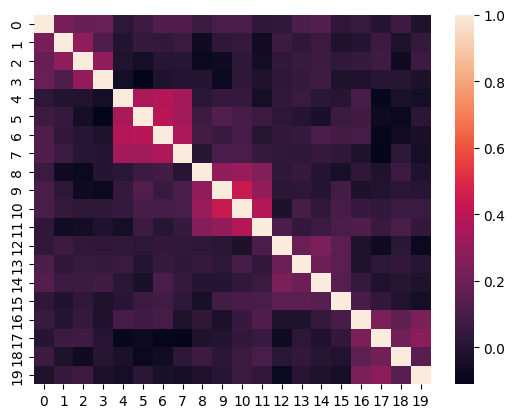

In [20]:
patg_sim_matrx = 'output/aya_dataset_500000_clustered_c20s2_i10_b16a1_l512_r8a16_20240912202551/similarity_B_round50.npy'

sim_matrix = np.load(patg_sim_matrx)
sns.heatmap(sim_matrix)

In [39]:
languages = ['English', 'Swedish', 'German', 'Portuguese', 'Spanish']
dataset = load_dataset("CohereForAI/aya_dataset", split="train")
dataset = dataset.filter(lambda x: x['language'] in languages)

Found cached dataset parquet (/home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-11e8f7e034e2f0b5.arrow


In [40]:
num_clients = 20
seed = 42

In [41]:
dataset = dataset.shuffle(seed=seed)        # Shuffle the dataset
local_datasets = []

Loading cached shuffled indices for dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-34522a74f434dfd7.arrow


In [ ]:
languages = ['English', 'Swedish', 'German', 'Portuguese', 'Spanish']
n_clients_in_cluster = num_clients // len(languages)

for i in range(num_clients):
    language = languages[i // n_clients_in_cluster]
    cluster_dataset = dataset.filter(lambda x: x['language'] == language)
    cluster_dataset = cluster_dataset.shuffle(seed=seed)

    local_datasets.append(cluster_dataset.shard(n_clients_in_cluster, i % n_clients_in_cluster))

In [47]:
local_datasets[0]

Dataset({
    features: ['inputs', 'targets', 'language', 'language_code', 'annotation_type', 'user_id'],
    num_rows: 986
})

In [48]:
local_datasets[1]

Dataset({
    features: ['inputs', 'targets', 'language', 'language_code', 'annotation_type', 'user_id'],
    num_rows: 986
})

In [33]:
local_datasets[5]['inputs'][:10]

['Fråga: När kom Bill of Rights ut? Svar:',
 'Slutför den här frasen: På Oscarsgalan',
 'Vilket är Sveriges minsta landskap till ytan?',
 'Skriv en fortsättning på den här paragrafen - Hamilton blev officer vid infanteriet 1872, överste 1891, generalmajor 1899, generallöjtnant 1901, general 1907 och erhöll avsked 1919. Hamilton deltog i kriget mot Afghanistan 1878-80 och mot boerna 1881, där han svårt sårades i slaget vid Majuba, samt vidare i fälttågen i Egypten 1884-85 och Burma 1886-87. Efter huvudsaklig tjänstgöring i Indien blev han vid',
 'Skriv en fortsättning på den här paragrafen - Partiet spelade en viktig roll både direkt och indirekt under den avgörande period i iransk historia som började med 1951 års nationalisering av British Anglo Iranian Oil Company (AIOC), och slutade med den',
 'Slutför den här frasen: Den finska paviljongen "Lumi", som utformas som ett arabiskt tält täckt av snö, har skapats av "JKMM Architects" som också skapade Finlands paviljong vid',
 'Skriv en 

In [14]:
local_datasets[6]['inputs'][:10]

NameError: name 'local_datasets' is not defined